# HMC for price forecasting

In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from hmmlearn import hmm
from tqdm import tqdm

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Ruta al archivo CSV
csv_path = "./coffee_weekly.csv"  # Reemplaza con la ruta a tu archivo CSV

try:
    # Usa pandas para leer el archivo CSV
    used_data = pd.read_csv(csv_path)
except FileNotFoundError:
    print("Archivo CSV no encontrado. Por favor, verifica la ruta del archivo.")
    sys.exit()
    
test_size = 0.3
    
# No mezcles los datos ya que es una serie temporal
_train_data, test_data = train_test_split(used_data, test_size=test_size, shuffle=False)

# Elimina las columnas que no se usan
train_data = _train_data.drop(["Volume", "Adj Close"], axis=1)  
test_data = test_data.drop(["Volume", "Adj Close"], axis=1) 

train_data.dropna(inplace=True)

In [3]:
# Parametros
n_components = 3
n_latency_days = 5
n_intervals = 15
days = len(test_data)

# Extrae las características: precios de apertura, cierre, máximo y mínimo
open_price = np.array(train_data["Open"])
close_price = np.array(train_data["Close"])
high_price = np.array(train_data["High"])
low_price = np.array(train_data["Low"])

# Calcula los cambios fraccionales en los precios alto, bajo y de cierre para usar como conjunto de observaciones
frac_change = (close_price - open_price) / open_price
frac_high = (high_price - open_price) / open_price
frac_low = (open_price - low_price) / open_price

# Apila las características en columnas
features = np.column_stack((frac_change, frac_high, frac_low))

# Inicializa el modelo HMM
hmm_1 = hmm.GMMHMM(n_components)

# Registro de la extracción de características
observations = features 

# Ajusta el modelo HMM usando la función 'fit' de hmmlearn
hmm_1.fit(observations)

# Parámetros para los intervalos
n_intervals_frac_change = n_intervals
n_intervals_frac_high = n_intervals  
n_intervals_frac_low = n_intervals

# Crea arrays de NumPy con números espaciados uniformemente para cada rango
frac_change_range = np.linspace(-0.1, 0.1, n_intervals_frac_change)
frac_high_range = np.linspace(0, 0.1, n_intervals_frac_high)
frac_low_range = np.linspace(0, 0.1, n_intervals_frac_low)

# Calcula todos los resultados posibles utilizando el producto cartesiano
possible_outcomes = np.array(
list(itertools.product(frac_change_range, frac_high_range, frac_low_range))
)

In [4]:
def predictor(day_index):

    # Usa los datos anteriores de n_latency_days para las predicciones
    previous_data_start_index = max(0, day_index - n_latency_days)
    previous_data_end_index = max(0, day_index - 1)
    previous_data = test_data.iloc[previous_data_start_index:previous_data_end_index]

    outcome_score = []

    # Evalúa todos los resultados posibles y selecciona el más probable para usar en la predicción
    for possible_outcome in possible_outcomes:
        total_data = np.row_stack((features, possible_outcome))
        outcome_score.append(hmm_1.score(total_data))

    # Obtén el índice del resultado más probable y devuélvelo
    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

    # Obtén el precio de apertura para el día dado
    open_price = test_data.iloc[day_index]["Open"]

    # Supongamos que 'most_probable_outcome' contiene los cambios fraccionales más probables en [frac_change, frac_high, frac_low]
    predicted_frac_change, pred_frac_high, pred_frac_low = most_probable_outcome
    predicted_change_list.append(predicted_frac_change)

    # Calcula el precio de cierre previsto
    predicted_close_price = open_price * (1 + predicted_frac_change)

    # Obtén la fecha correspondiente al day_index
    date_at_day_index = test_data.iloc[day_index]['Date']
    
    return predicted_close_price, date_at_day_index

In [5]:
# Inicializa una lista vacía para almacenar los precios de cierre previstos
predicted_close_prices = []
predicted_dates = []
predicted_change_list = []

# Imprime el rango de fechas para las que se harán las predicciones
print(
    "Predicting Close prices from "
    + str(test_data.index[0])
    + " to "
    + str(test_data.index[-1])
)

# Bucle para predecir los precios de cierre para cada día en el período de prueba
for day_index in tqdm(range(days)):
    value, date = predictor(day_index)
    predicted_close_prices.append(value)
    predicted_dates.append(date)

Predicting Close prices from 870 to 1242


  0%|          | 0/373 [00:00<?, ?it/s]

 11%|█▏        | 42/373 [03:37<28:30,  5.17s/it]


KeyboardInterrupt: 

In [ ]:
# Extraer los años de las fechas predichas
years = [date.split("-")[0] for date in used_data['Date']]

# Eliminar años duplicados
unique_years = list(set(years))

# Encontrar los índices donde cambian los años
year_indices = [years.index(year) for year in unique_years]

In [8]:
# Almacena y devuelve los precios de cierre reales
actual_close_prices = test_data.loc[:, ["Close"]]

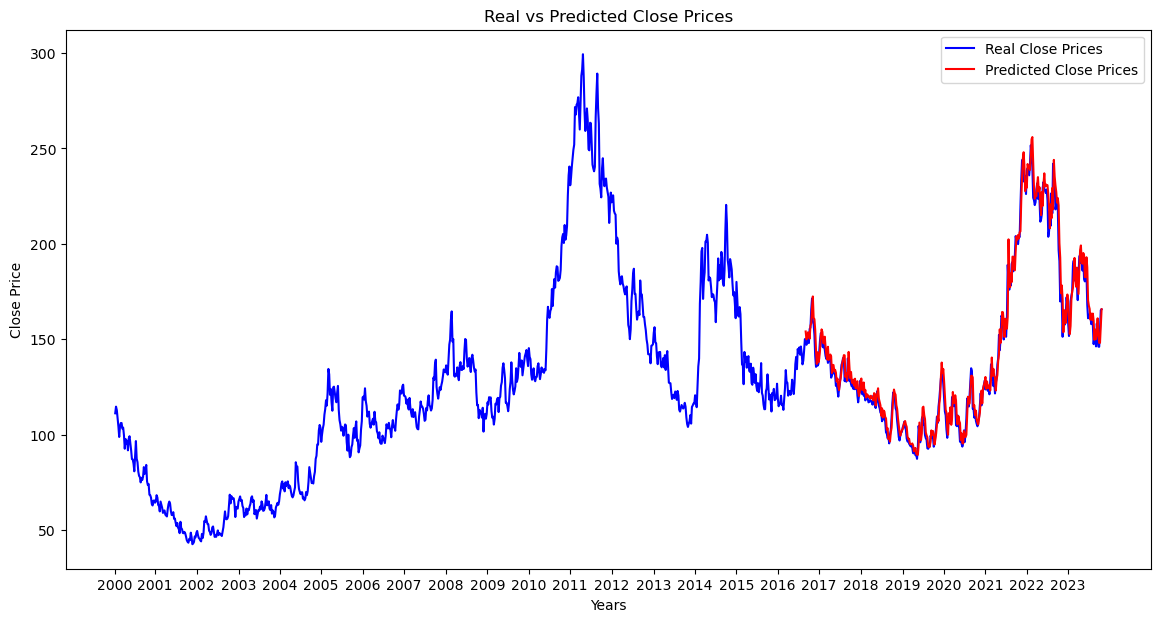

In [26]:


# Convertir 'actual_close_prices' a una lista si es un DataFrame de pandas
if isinstance(actual_close_prices, pd.DataFrame):
    actual_close_prices = actual_close_prices["Close"].tolist()

# Crear el gráfico
plt.figure(figsize=(14, 7))

# Trazar los precios de cierre reales
plt.plot(used_data.loc[:, ["Close"]], label='Real Close Prices', color='blue')

# Trazar los precios de cierre previstos
plt.plot(range(len(train_data), len(train_data) + len(predicted_close_prices)), predicted_close_prices, label='Predicted Close Prices', color='red')

# Añadir título y etiquetas
plt.title('Real vs Predicted Close Prices')
plt.xlabel('Years')
plt.ylabel('Close Price')
plt.legend()

# Configurar las etiquetas de los xticks con los años únicos
plt.xticks(ticks=year_indices, labels=unique_years)

# Mostrar el gráfico
plt.show()

In [27]:
error_abs = abs(np.array(actual_close_prices) - np.array(predicted_close_prices))/np.array(actual_close_prices) 
error_10days = error_abs.mean()
error_10days

0.03508835151093526

In [28]:
# Function to predict the next day's closing price based on the last n_latency_days in the dataset
def predict_next_day():
    # Use the last n_latency_days from the test set for the prediction
    last_days_data = test_data.iloc[-n_latency_days:]

    outcome_score = []

    for possible_outcome in possible_outcomes:
        total_data = np.row_stack((features[-n_latency_days:], possible_outcome))
        outcome_score.append(hmm_1.score(total_data))

    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]

    last_open_price = last_days_data.iloc[-1]["Open"]
    predicted_frac_change, _, _ = most_probable_outcome
    predicted_close_price = last_open_price * (1 + predicted_frac_change)

    return predicted_close_price

# Predict the next day's closing price
next_day_predicted_price = predict_next_day()
print(f'Predicted closing price for the next day: {next_day_predicted_price}')

Predicted closing price for the next day: 165.73427962857141


# Buy, Sell and Hold Signals

In [6]:
# Simulated historical close prices (replace with your actual data)
historical_close_prices = used_data['Close']

# Calculate the fractional changes in close prices
frac_changes = [(historical_close_prices[i] - historical_close_prices[i-1]) / historical_close_prices[i-1] for i in range(1, len(historical_close_prices))]

# Calculate the average and standard deviation of the fractional changes
avg_frac_change = np.mean(frac_changes)
std_frac_change = np.std(frac_changes)

# Set the buy and sell thresholds based on the historical analysis
# Here, we set the threshold as the average plus/minus one standard deviation
buy_threshold = avg_frac_change + std_frac_change
sell_threshold = avg_frac_change - std_frac_change

# Create a DataFrame to display the calculated thresholds
threshold_df = pd.DataFrame({
    'Threshold Type': ['Buy', 'Sell'],
    'Value': [buy_threshold, sell_threshold]
})

print('Calculated Buy and Sell Thresholds:')
print(threshold_df)

Calculated Buy and Sell Thresholds:
  Threshold Type     Value
0            Buy  0.044537
1           Sell -0.042075


In [15]:
# Inicializa una lista para almacenar las señales
trade_signals = []

# Define umbrales
buy_threshold = 0.044592 
sell_threshold = -0.042083
# Todo lo demás se considerará una señal de retención

# Generar señales de trading
for i in range(1, len(actual_close_prices)):
    real_close_price_prev_day = np.array(actual_close_prices)[i - 1]
    predicted_close_price_today = np.array(actual_close_prices)[i]

    # Calcula el cambio fraccional predicho
    predicted_frac_change = (predicted_close_price_today - real_close_price_prev_day) / real_close_price_prev_day

    # Genera señales de trading
    if predicted_frac_change > buy_threshold:
        trade_signals.append('Compra')
    elif predicted_frac_change < sell_threshold:
        trade_signals.append('Venta')
    else:
        trade_signals.append('Retención')

# Agrega una señal de 'Retención' para el primer día
trade_signals.insert(0, 'Retención')

In [16]:
# Calculate the predicted fractional change
predicted_frac_change = (next_day_predicted_price - test_data['Close'].iloc[-1]) / test_data['Close'].iloc[-1]

if predicted_frac_change > buy_threshold:
    trade_signal = 'Compra'
elif predicted_frac_change < sell_threshold:
    trade_signal = 'Venta'
else:
    trade_signal = 'Retención'

print(f'La señal de trading para el valor predicho es: {trade_signal}')

NameError: name 'next_day_predicted_price' is not defined

In [21]:
data_change = test_data.copy()
data_change['Signal'] = trade_signals
data_change.head(10)

,Date,Open,High,Low,Close,Signal
870,2016-09-05,151.899994,153.699997,150.000000,149.949997,Retención
871,2016-09-12,147.800003,149.300003,147.000000,147.100006,Retención
872,2016-09-19,149.300003,160.899994,149.300003,151.399994,Retención
873,2016-09-26,151.500000,154.949997,148.750000,151.550003,Retención
874,2016-10-03,151.100006,151.699997,145.199997,148.000000,Retención
875,2016-10-10,148.199997,155.899994,148.050003,155.399994,Compra
876,2016-10-17,154.899994,159.600006,154.550003,156.100006,Retención
877,2016-10-24,156.050003,166.899994,155.649994,165.500000,Compra
878,2016-10-31,164.250000,172.000000,160.350006,171.350006,Retención
879,2016-11-07,170.000000,176.000000,157.899994,159.449997,Venta


In [28]:
buy_signal = data_change[data_change["Signal"] == "Compra"]
sell_signal = data_change[data_change["Signal"] == "Venta"]

sum1 = 0

for i in buy_signal.index:
    retur = (data_change["Close"][i+1] - data_change["Close"][i])/data_change["Close"][i]
    sum1 += retur

for j in sell_signal.index:
    retur = -(data_change["Close"][i+1] - data_change["Close"][i])/data_change["Close"][i]
    sum1 += retur

sum1

0.4415733891545848

In [19]:
data3 =data_change.reset_index()
(data3['Close'][len(data3)-1] - data3['Close'][0])/ data3['Close'][0]

0.10470154927712334

(array([263.,   0.,   0.,   0.,   0.,  59.,   0.,   0.,   0.,  51.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

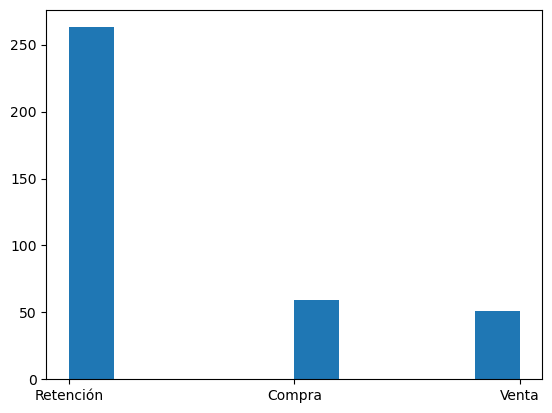

In [29]:
plt.hist(data_change['Signal'])